In [1]:
import csv
import pandas as pd
import numpy as np
import operator
import xgboost
from xgboost import XGBRegressor 
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the datasets
train = pd.read_csv(r'all\train.csv', sep = ',')
test = pd.read_csv(r'all\test.csv', sep = ',')

In [3]:
# creating a dict with columns as keys and number of nan as values
nan_dict = {}
for col in test:
    nan_count = test[test[col].isna()]
    if len(nan_count) > 0:
        nan_dict[col] = len(nan_count)

# list sorted in descending order of nan values        
sorted_nan = sorted(nan_dict.items(), key = operator.itemgetter(1))
sorted_nan.reverse()

## Data cleaning

#### Dealing with the bias

In [4]:
# shrinking the range of SalePrice in order to reduce the bias of the fit function
train.loc[(train.SalePrice < 38000), 'SalePrice'] = train.SalePrice + 8000
train.loc[(train.SalePrice > 620000), 'SalePrice'] = train.SalePrice - 27000

#### Removing the outliers

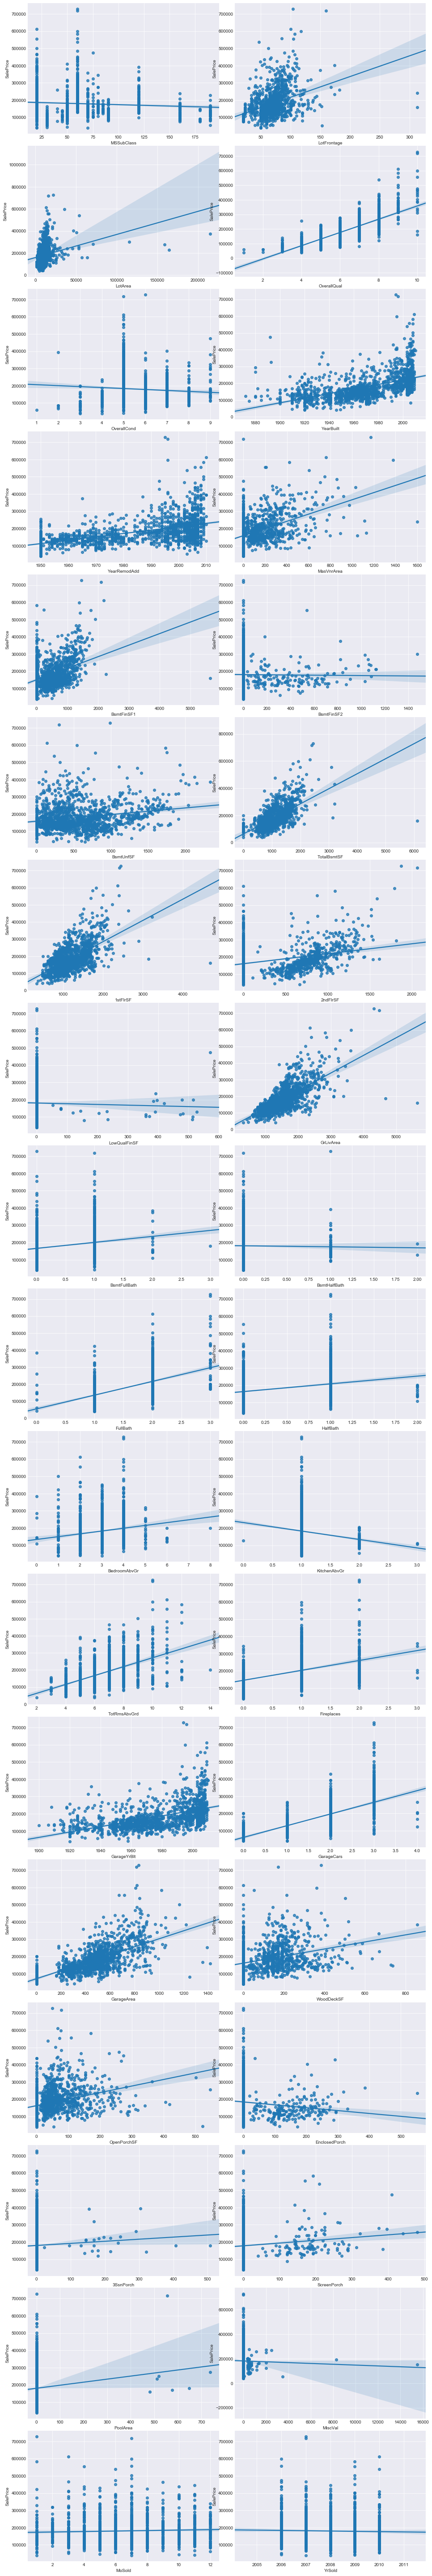

In [5]:
# searching the ouliers via visualization of correlation between each numerical feature and SalePrice
fig, ax = plt.subplots(18, 2, 'row', figsize = (13, 80))
plt.tight_layout()
i = 1
for feature in train.columns:
    if feature != 'Id' and feature != 'SalePrice':
        if train[feature].dtype == 'int64' or train[feature].dtype == 'float64':
            plt.subplot(18, 2, i)
            sns.regplot(x = train[feature], y = train['SalePrice'])
            plt.xlabel(feature)
            i += 1

In [6]:
train = train.drop(train[(train.LotArea > 200000) & (train.SalePrice < 300000)].index)
train = train.drop(train[train.LotArea > 60000].index)
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 200000)].index)
train = train.drop(train[(train.LotFrontage > 300) & (train.SalePrice < 300000)].index)

#### Features transformation 

In [7]:
# actually 'MSSubClass' is a categorical feature
# its values are numerical codes so we treat them as string
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)

In [8]:
# creating new features from existing ones
train['TotFlrSF'] = train['1stFlrSF'] + train['2ndFlrSF']
test['TotFlrSF'] = test['1stFlrSF'] + test['2ndFlrSF']
train['TotBsmtBath'] = train['BsmtFullBath'] + train['BsmtHalfBath']
test['TotBsmtBath'] = test['BsmtFullBath'] + test['BsmtHalfBath']
# the old features will be dropped

#### Dealing with NaN values

In [9]:
# list of numerical features whose nan values will be replaced with a constant value (in this case 0) 
numerical_feature_nan_to_zero = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars'] 
# list of categorical features whose nan values will be replaced with a constant value (in this case None) 
string_feature_nan_to_none = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageCond', 
                                'GarageType', 'MasVnrType']

In [10]:
# list of feature to drop: they have a number of nan values greater than 200
drop_col = [tup[0] for tup in sorted_nan[:6]]
# columns to imputate
imp_col = [tup[0] for tup in sorted_nan[6:]]

#### Dropping the features

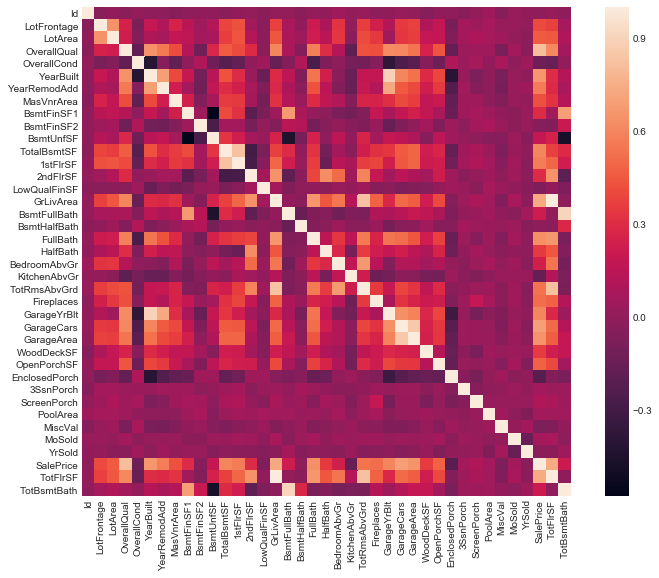

In [11]:
# heat map of correlation matrix
corr = train.corr(method = 'spearman')
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr, vmax = 1, square = True);

In [12]:
# list of features to drop (not significant, strongly correlated with certain others, not correlated with SalePrice)
to_drop = drop_col + ['Id', 'Utilities', 'Condition2', 'TotRmsAbvGrd', 'Functional', 
                      'GarageArea', 'WoodDeckSF', 'RoofMatl', 'TotalBsmtSF',
                      'GarageFinish', '1stFlrSF', '2ndFlrSF', 'MasVnrArea',
                      'BsmtFullBath', 'BsmtHalfBath', 'MSZoning', 'KitchenQual',
                      'LandContour', 'LotConfig', 'LandSlope', 'RoofStyle', 
                      'RoofMatl','Exterior1st', 'Exterior2nd', 'Foundation', 
                      'BsmtQual', 'BsmtCond', 'Electrical', 'GarageQual'] 

dropped_test = test.drop(to_drop, axis = 1)
dropped_train = train.drop(to_drop, axis = 1)

In [13]:
# distinguishing categorical and numeric features
str_feature = [i for i in dropped_test.columns if isinstance(dropped_test[i][0], str)]
num_feature = [i for i in (set(dropped_test.columns).difference(str_feature))]

In [14]:
# distinguishing the categorical features from ones that have nan values to be replaced with the None value 
str_featureSet = set(str_feature)
str_featureSet -= set(string_feature_nan_to_none)

str_feature = list(str_featureSet)

In [15]:
# make copy to avoid changing original data (when Imputing)
new_test = dropped_test.copy()
new_train = dropped_train.copy()
reduced_train = new_train.drop('SalePrice', axis = 1)

# the target variable is skewed so we need to make it normally distributed
final_train_y = np.log1p(train['SalePrice'].astype('float'))

# string conversion from nan to None
str_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'None')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

# numeric conversion from nan to a constant value (i.e. 0)
num_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler())])

# we use StandardScaler to normalize the features before applying machine learning techniques

# numeric conversion from nan to median
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

# string conversion from nan to most_frequent
str_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers = [('cat_std', str_default_transformer, string_feature_nan_to_none),
        ('num_std', num_default_transformer, numerical_feature_nan_to_zero),
        ('num', num_transformer, num_feature),
        ('cat', str_transformer, str_feature)])

# Modelling

In [16]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', LassoCV(eps = 1e-3, cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions1 = clf.predict(new_test) 

print(clf.score(reduced_train, final_train_y))

0.9319432436379423


In [17]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                ('classifier', RidgeCV(cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions2 = clf.predict(new_test)

print(clf.score(reduced_train, final_train_y))  

0.9329742950460032


In [18]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', XGBRegressor(n_estimators = 1000))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions3 = clf.predict(new_test)

print(clf.score(reduced_train, final_train_y)) 

0.9932373889989148


In [19]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', ElasticNetCV(cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions4 = clf.predict(new_test)

print(clf.score(reduced_train, final_train_y)) 

0.9318363011940303


In [20]:
predictions = (predictions1 + predictions2 + predictions3 + predictions4)/4

In [21]:
# converting the log prices into the real SalePrice values
pred_sale_price = pd.DataFrame(np.expm1(predictions), 
                               columns = ['SalePrice'], index = None)
pred_sale_price['Id'] = test['Id']

# rounding the prices to the nearest 100 multiple
myround = 100
pred_sale_price['SalePrice'] = ((pred_sale_price['SalePrice'] + 
                                 (myround/2))/ myround).astype(int) * myround


# Creating the output

In [22]:
cols = pred_sale_price.columns.tolist()
cols = cols[-1:] + cols[:-1]
pred_sale_price = pred_sale_price[cols]
pred_sale_price.to_csv('predictions.csv', index = False)